<h1>T cell autonomous gating</h1>

In this notebook we detail autonomous gating for the identification of T cell subsets and compare the ability of autonomous gates to identify these subsets compared to manual gates.

<h2>Generating a gating strategy</h2>

The first step in autonomous gating is to define `Gate`'s and a `GatingStrategy`. This will then be applied to samples in an experiment without any supervision for autonomous identification of cell subsets.

In [2]:
# CytoPy imports
from CytoPy.data.project import Project
from CytoPy.data.setup import global_init
from CytoPy.data.gating_strategy import *
# Connect to local database
global_init("cytopy_db")

In [3]:
# Other plotting imports
import seaborn as sns
sns.set(style="white", font_scale=1.2)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [6]:
# Load project
project = Project.objects(project_id="Peritonitis").get()

In [8]:
exp = project.load_experiment("PBMC T cells")

In [5]:
# We use the same reference sample identified in previous notebook as example data
reference = "305-02"

In [7]:
# Start by creating a GatingStrategy object
gates = GatingStrategy(name="T cell gating")

In [8]:
# Load data from our experiment
gates.load_data(experiment=exp, sample_id=reference)

Once we have a sample loaded into your `GatingStrategy` we can plot populations using the `plot_population` method.

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

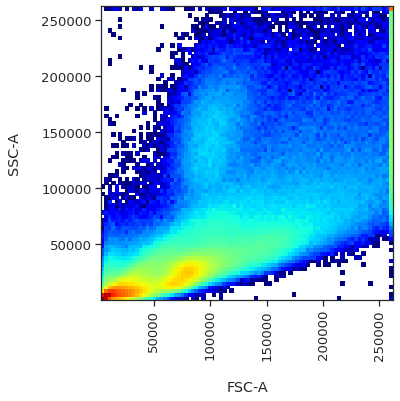

In [9]:
gates.plot_population("root", "FSC-A", "SSC-A", 
                      transform_x=None, transform_y=None,
                      create_plot_kwargs={"autoscale": False})

The first gate is static and simply identifies a large subset of data in forward and sideward scatter channels, with the objective to remove large debris. The gate is defined using the `PolygonGate` object and previewed with the `preview_gate` method of our `GatingStrategy`:

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

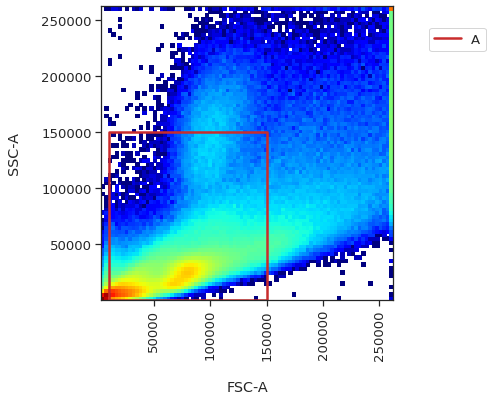

In [10]:
cell_gate = PolygonGate(gate_name="cell_gate",
                        parent="root",
                        x="FSC-A",
                        y="SSC-A",
                        transform_x=None,
                        transform_y=None,
                        method="manual",
                        method_kwargs={"x_values": [10000, 150000, 150000, 10000, 10000],
                                       "y_values": [0, 0, 150000, 150000, 0]})
gates.preview_gate(cell_gate, create_plot_kwargs={"autoscale": False})

We label this region with a population name and then apply the gate to generate the population.

In [11]:
cell_gate.label_children({"A": "ag_Cells"})
gates.apply_gate(cell_gate, plot=False)

----- cell_gate -----
Parent (root) n: 3143219
...child ag_Cells n: 1813490; 57.69531171706458% of parent
------------------------


Next we want to identfy the CD$3^{+}$ subset of this cell population. This can be achieved with the `ThresholdGate` class, separating data based on regions of minimum and maximum density. Below we specify one dimension and therefore it will try to seperate populations in a single dimension:

<AxesSubplot:xlabel='CD3'>

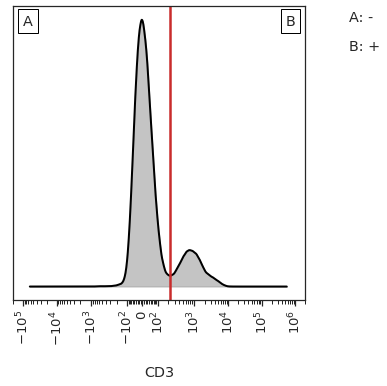

In [12]:
cd3_gate = ThresholdGate(gate_name="cd3_gate",
                       parent="ag_Cells",
                       x="CD3",
                       transform_x="logicle",
                       method="density")
gates.preview_gate(cd3_gate)

In [13]:
cd3_gate.label_children({"+": "ag_CD3+", "-": "ag_CD3-"})
gates.apply_gate(cd3_gate, plot=False)

----- cd3_gate -----
Parent (ag_Cells) n: 1813490
...child ag_CD3+ n: 286781; 15.813762413909094% of parent
...child ag_CD3- n: 1526709; 84.18623758609091% of parent
------------------------


As discussed in the manuscript, to account for batch effect we perform local normalisation. We can tell the `GatingStrategy` to remember to normalise any future data encountered when appling the CD3 gate using the `add_normalisation` method:

In [14]:
gates.add_normalisation("cd3_gate")

Next we use the `ThresholdGate` to remove dead cells:

<AxesSubplot:xlabel='LD'>

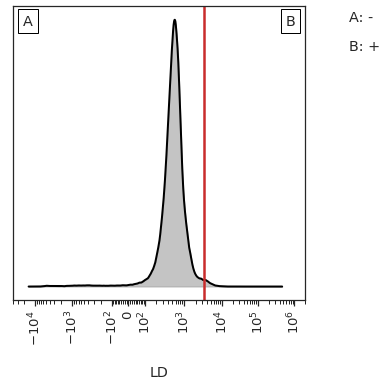

In [15]:
live_gate = ThresholdGate(gate_name="live_gate",
                       parent="ag_CD3+",
                       x="LD",
                       transform_x="logicle",
                       method="density")
gates.preview_gate(live_gate)

In [16]:
live_gate.label_children({"+": "ag_CD3+ Dead/CD14+", "-": "ag_Live CD3+"})
gates.apply_gate(live_gate, plot=False)

----- live_gate -----
Parent (ag_CD3+) n: 286781
...child ag_CD3+ Dead/CD14+ n: 2688; 0.9373005882537546% of parent
...child ag_Live CD3+ n: 284093; 99.06269941174625% of parent
------------------------


The 'dead' population might vary in size and normalisation alone won't be enough to handle variation between samples. Therefore we also add a 'hyperparameter grid', that is, a set of hyperparameters that the `GatingStrategy` will search when applying the gate to new data. The populations that are most similar to what we observed in the example data will be kept. Adding a hyperparameter grid is simple, we just pass the name of the gate and a dictionary of hyperparameters to `add_hyperparameter_grid` method:

In [17]:
gates.add_normalisation("live_gate")
gates.add_hyperparameter_grid("live_gate", {"min_peak_threshold": [0.05, 0.1, 0.25],
                                            "peak_boundary": [0.1, 0.2, 0.5]})

<AxesSubplot:xlabel='FSC-A', ylabel='FSC-H'>

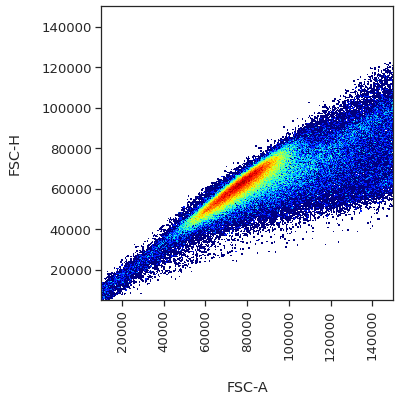

In [18]:
gates.plot_population("ag_Live CD3+", "FSC-A", "FSC-H", 
                      transform_x=None, transform_y=None)

Next we perform singlet gating using the `EllipseGate`. Here we tell it to use the `GaussianMixture` class from Scikit-Learn and identify two components. We also specify a wide gate by setting conf to 0.999.

<AxesSubplot:xlabel='FSC-A', ylabel='FSC-H'>

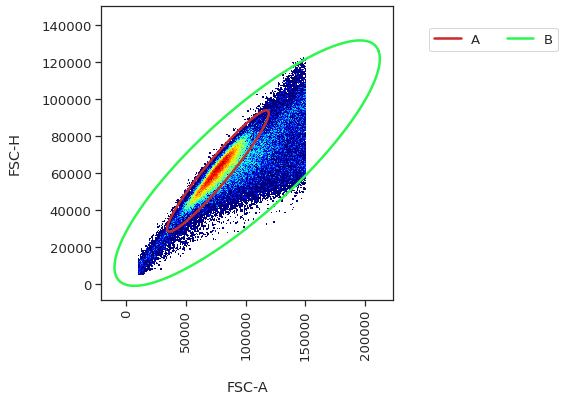

In [19]:
singlets_gate = EllipseGate(gate_name="singlets_gate",
                            parent="ag_Live CD3+",
                            x="FSC-A",
                            y="FSC-H",
                            transform_x=None,
                            transform_y=None,
                            method="GaussianMixture",
                            method_kwargs={"n_components": 2, "conf": 0.999})
gates.preview_gate(singlets_gate)

In [20]:
# By labelling A and not B, we're telling the gate to ignore B
singlets_gate.label_children({"A": "ag_Single Live CD3+"})
gates.apply_gate(singlets_gate, plot=False)

----- singlets_gate -----
Parent (ag_Live CD3+) n: 284093
...child ag_Single Live CD3+ n: 223972; 78.83756375553077% of parent
------------------------


2 components might not be optimal for all data, so we give a range of values to explore when applying this gate.

In [21]:
gates.add_hyperparameter_grid("singlets_gate", {"n_components": [1, 2, 3]})

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

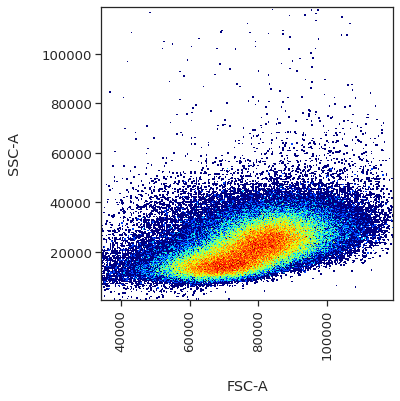

In [22]:
gates.plot_population("ag_Single Live CD3+", "FSC-A", "SSC-A", transform_x=None, transform_y=None)

Finally we use an `EllipseGate` again to home in on our T cells.

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

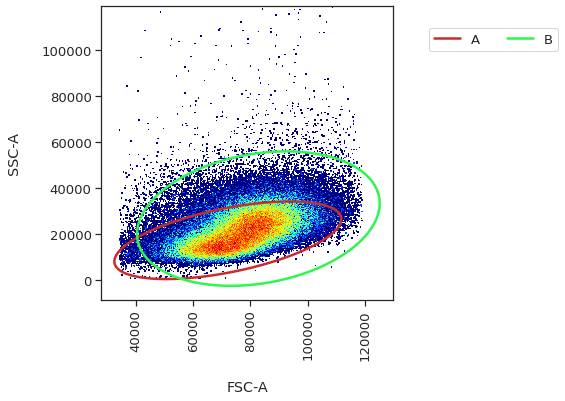

In [23]:
tcell_gate = EllipseGate(gate_name="tcell_gate",
                            parent="ag_Single Live CD3+",
                            x="FSC-A",
                            y="SSC-A",
                            transform_x=None,
                            transform_y=None,
                            method="GaussianMixture",
                            method_kwargs={"n_components": 2, "conf": 0.999})
gates.preview_gate(tcell_gate)

In [24]:
tcell_gate.label_children({"B": "ag_T cells"})
gates.apply_gate(tcell_gate, plot=False)

----- tcell_gate -----
Parent (ag_Single Live CD3+) n: 223972
...child ag_T cells n: 222134; 99.17936170592753% of parent
------------------------


In [25]:
gates.add_hyperparameter_grid("tcell_gate", {"n_components": [1, 2, 3, 4, 5]})

Below we plot our T cell population to try and identify V$\delta$2$^{+} \gamma\delta$ T cells. Notice this is the first time we encounter the transform methods. We can use logicle, hyperlog, hyperbolic arcsine and log transformations for our plots and gates.

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

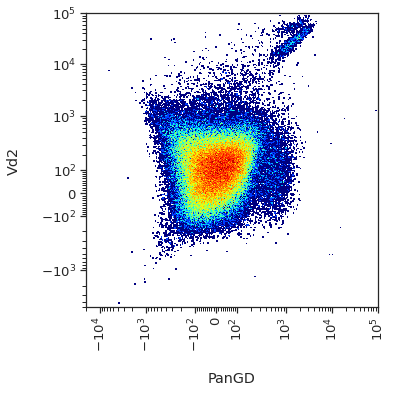

In [26]:
gates.plot_population("ag_T cells", "PanGD", "Vd2", transform_x="logicle", transform_y="logicle")

I'll use a 2D threshold gate to seperate $\gamma\delta$ T cells then apply an additional gate to seperate the V$\delta$2$^{+} \gamma\delta$ T cells.

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

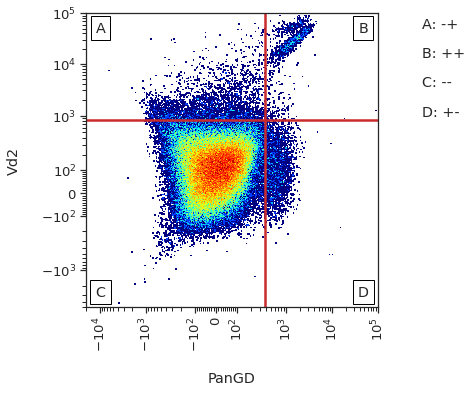

In [30]:
gdt_gate = ThresholdGate(gate_name="gdt_gate",
                         parent="ag_T cells",
                         x="PanGD",
                         y="Vd2",
                         transform_x="logicle",
                         transform_y="logicle",
                         method="density",
                         method_kwargs={"min_peak_threshold": 0.1, "peak_boundary": 0.5})
gates.preview_gate(gdt_gate)

----- gdt_gate -----
Parent (ag_T cells) n: 222134
...child ag_GDT cells n: 9006; 4.054309560895676% of parent
...child ag_Not GDT cells n: 213128; 95.94569043910433% of parent
------------------------


<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

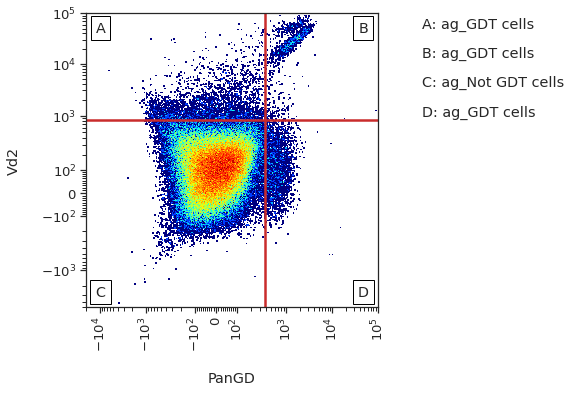

In [31]:
gdt_gate.label_children({"-+": "ag_GDT cells",
                         "++": "ag_GDT cells",
                         "+-": "ag_GDT cells",
                         "--": "ag_Not GDT cells"})
gates.apply_gate(gdt_gate)

In [33]:
# Add normalisation and hyperparameter search to help generalise to other data
gates.add_normalisation("gdt_gate")
gates.add_hyperparameter_grid("gdt_gate", {"min_peak_threshold": [0.1, 0.25], 
                                           "peak_boundary": [0.5]},
                              cost="threshold_dist")

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

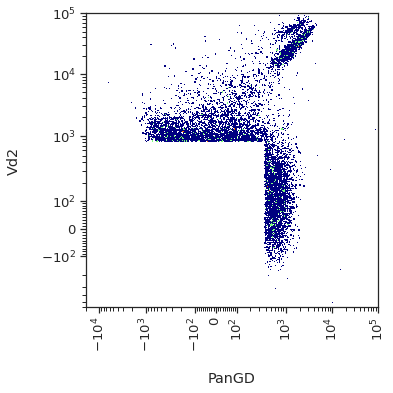

In [34]:
gates.plot_population("ag_GDT cells", "PanGD", "Vd2", 
                      transform_x="logicle", 
                      transform_y="logicle",
                      create_plot_kwargs={"bins": 1000})

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

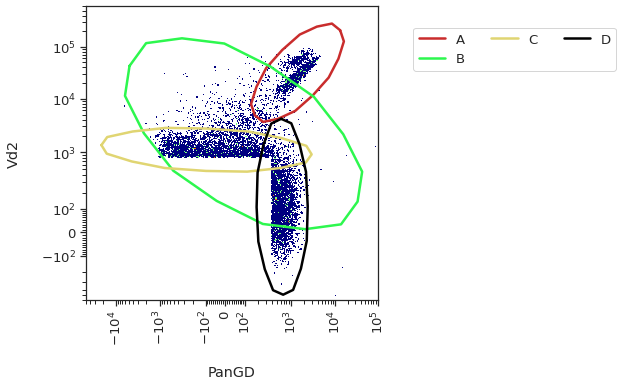

In [35]:
vd2GDT_gate = EllipseGate(gate_name="vd2GDT_gate",
                            parent="ag_GDT cells",
                            x="PanGD",
                            y="Vd2",
                            transform_x="logicle",
                            transform_y="logicle",
                            method="GaussianMixture",
                            method_kwargs={"n_components": 4, "conf": 0.999})
gates.preview_gate(vd2GDT_gate, create_plot_kwargs={"bins": 1000})

In [36]:
vd2GDT_gate.label_children({"A": "ag_Vd2+ GDT cells"})
gates.apply_gate(vd2GDT_gate, plot=False)

----- vd2GDT_gate -----
Parent (ag_GDT cells) n: 9006
...child ag_Vd2+ GDT cells n: 1703; 18.909615811681103% of parent
------------------------


In [37]:
gates.add_normalisation("vd2GDT_gate")
gates.add_hyperparameter_grid("vd2GDT_gate", {"n_components": [2, 3, 4, 5, 6]})

With V$\delta$2$^{+} \gamma\delta$ T cells identified, I use the remaining data to identify MAIT cells:

<AxesSubplot:xlabel='Va7-2', ylabel='CD161'>

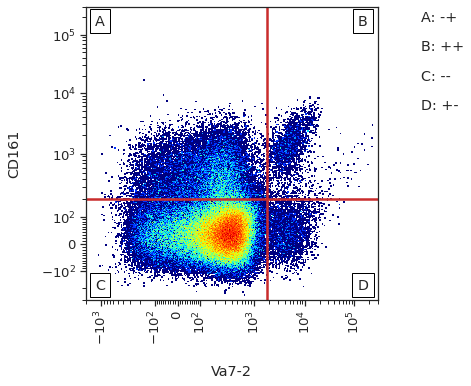

In [38]:
mait_gate = ThresholdGate(gate_name="mait_gate",
                       parent="ag_Not GDT cells",
                       x="Va7-2",
                       y="CD161",
                       transform_x="logicle",
                       transform_y="logicle",
                       method="density")
gates.preview_gate(mait_gate)

In [39]:
mait_gate.label_children({"-+": "ag_Classic T cells",
                         "--": "ag_Classic T cells",
                         "+-": "ag_Classic T cells",
                         "++": "ag_MAIT cells"})
gates.apply_gate(mait_gate, plot=False)

----- mait_gate -----
Parent (ag_Not GDT cells) n: 213128
...child ag_MAIT cells n: 2646; 1.241507450921512% of parent
...child ag_Classic T cells n: 210482; 98.7584925490785% of parent
------------------------


Then CD4$^{+}$ and CD8$^{+}$ T cells:

<AxesSubplot:xlabel='CD4', ylabel='CD8'>

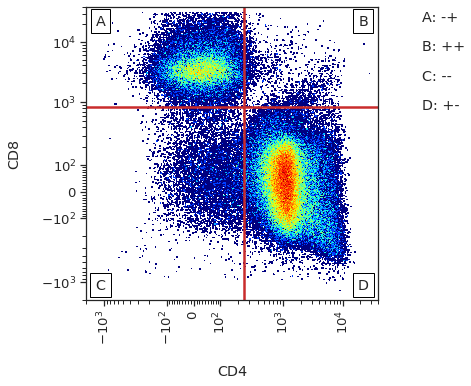

In [40]:
cd4cd8_gate = ThresholdGate(gate_name="cd4cd8_gate",
                       parent="ag_Classic T cells",
                       x="CD4",
                       y="CD8",
                       transform_x="logicle",
                       transform_y="logicle",
                       method="density")
gates.preview_gate(cd4cd8_gate)

In [41]:
cd4cd8_gate.label_children({"+-": "ag_CD4+ CD8- T cells",
                            "-+": "ag_CD4- CD8+ T cells"})
gates.apply_gate(cd4cd8_gate, plot=False)

----- cd4cd8_gate -----
Parent (ag_Classic T cells) n: 210482
...child ag_CD4+ CD8- T cells n: 157274; 74.72087874497582% of parent
...child ag_CD4- CD8+ T cells n: 43486; 20.66019897188358% of parent
------------------------


In [42]:
gates.add_hyperparameter_grid("cd4cd8_gate", {"min_peak_threshold": [0.01, 0.05, 0.1],
                                              "peak_threshold": [0.1, 0.2, 0.3]})

Finally we need to save the `GatingStrategy`. This means it now persists and can be applied to future data. When we call `save` both the `Gates`, `GatingStrategy` and any associated `FileGroup` is saved. If we want to save the `GatingStrategy` only we set `save_filegroup` to `False`, or, if we want to save the `FileGroup` only, we set `save_strategy` to `False`. In this case we want to save both, so we just call `save` with no parameters:

In [51]:
gates.save()

<h2>Apply gating strategy</h2>

Applying the `GatingStrategy` to new data is simple. We reload the strategy and call the `apply_to_experiment` method. We specify that we want to normalise data when defined for a gate and we want to perform hyperparameter search. We also tell it to produce a log so we can keep track of progress.

In [6]:
gates = GatingStrategy.objects(name="T cell gating").get()

In [ ]:
gates.apply_to_experiment(experiment=exp,
                          logging_path="auto_gates.log",
                          fda_norm=True,
                          hyperparam_search=True,
                          verbose=True)

<h2>Autonomous gates vs manual gates</h2>

Below we compare the results of our autonomous gates to manually gated results from the same dataset, stored in `manual_gates.csv`.

In [9]:
ag_stats = exp.population_statistics()

In [10]:
manual_stats = pd.read_csv("manual_gates.csv")

In [26]:
def auto_vs_manual(manual_population: str,
                   auto_population: str,
                   manual_stats: pd.DataFrame,
                   auto_stats: pd.DataFrame,
                   title: str):
    auto = (ag_stats[ag_stats.population_name == auto_population]
            [["sample_id", "n"]]
            .rename({"n": "Auto"}, axis=1))
    manual = (manual_stats[["sample_id", manual_population]]
              .rename({manual_population: "Manual"}, axis=1))
    stats = auto.merge(manual, on="sample_id")
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(stats.Auto.values, stats.Manual.values,
               edgecolor="black",
               color="#4e7abf",
               s=120,
               linewidth=2,
               zorder=1)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black", zorder=0)
    axis_lower_lim = np.min([np.min(ax.get_xlim()),
                             np.min(ax.get_ylim())])
    axis_upper_lim = np.max([np.max(ax.get_xlim()),
                             np.max(ax.get_ylim())])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Autonomous gates")
    ax.set_ylabel("Manual gates")
    ax.set_title(title)
    return ax, stats

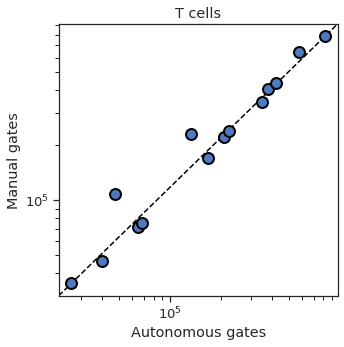

In [29]:
ax, _ = auto_vs_manual(manual_population="Live single CD3+ cells",
                   auto_population="ag_T cells",
                   manual_stats=manual_stats,
                   auto_stats=ag_stats,
                      title="T cells")
plt.savefig("figures/autogate_tcells.png", dpi=300, facecolor="white",
            bbox_inches="tight")

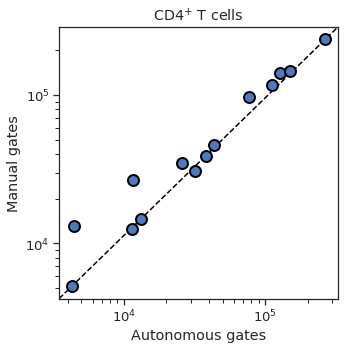

In [30]:
ax, _ = auto_vs_manual(manual_population="CD4- CD8+ T cells",
                   auto_population="ag_CD4- CD8+ T cells",
                   manual_stats=manual_stats,
                   auto_stats=ag_stats,
                      title="CD$4^{+}$ T cells")
plt.savefig("figures/autogate_cd4.png", dpi=300, facecolor="white",
            bbox_inches="tight")

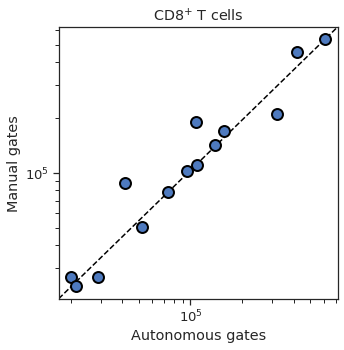

In [31]:
ax, _ = auto_vs_manual(manual_population="CD4+ CD8- T cells",
                   auto_population="ag_CD4+ CD8- T cells",
                   manual_stats=manual_stats,
                   auto_stats=ag_stats,
                      title="CD$8^{+}$ T cells")
plt.savefig("figures/autogate_cd8.png", dpi=300, facecolor="white",
            bbox_inches="tight")

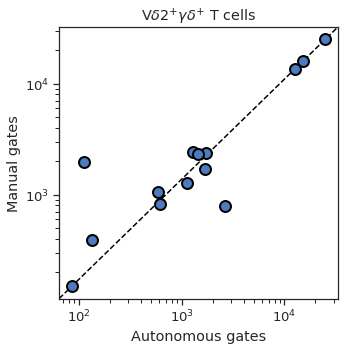

In [32]:
ax, _ = auto_vs_manual(manual_population="Vd2+ GDTs",
                       auto_population="ag_Vd2+ GDT cells",
                       manual_stats=manual_stats,
                       auto_stats=ag_stats,
                      title="V$\delta 2^{+} \gamma\delta^{+}$ T cells")
plt.savefig("figures/autogate_gdt.png", dpi=300, facecolor="white",
            bbox_inches="tight")

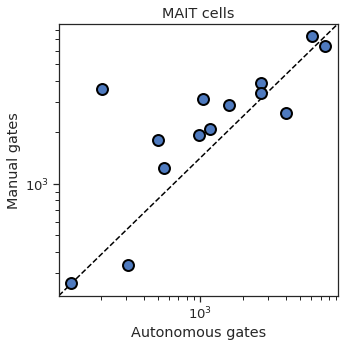

In [33]:
ax, _ = auto_vs_manual(manual_population="MAIT cells",
                       auto_population="ag_MAIT cells",
                       manual_stats=manual_stats,
                       auto_stats=ag_stats,
                      title="MAIT cells")
plt.savefig("figures/mait.png", dpi=300, facecolor="white",
            bbox_inches="tight")